In [1]:
import numpy as np
import pandas as pd 
import pickle
import json
import gensim
import os
import re

from sklearn.model_selection import train_test_split
from pandas.plotting import scatter_matrix

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing import sequence
from keras.optimizers import RMSprop, SGD
from keras.models import Sequential, Model
from keras.layers.core import Dense, Dropout, Activation, Flatten, Reshape
from keras.layers import Input, Bidirectional, LSTM, regularizers
from keras.layers.embeddings import Embedding
from keras.layers.convolutional import Conv1D, MaxPooling1D, MaxPooling2D, Conv2D
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping


%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
# Change these to match your file paths :)
filename = '../../wyns/data/tweet_global_warming.csv' #64,706 reviews

In [3]:
model_path = "GoogleNews-vectors-negative300.bin"
word_vector_model = gensim.models.KeyedVectors.load_word2vec_format(model_path, binary=True)

In [4]:
def normalize(txt, vocab=None, replace_char=' ',
                max_length=300, pad_out=False,
                to_lower=True, reverse = False,
                truncate_left=False, encoding=None,
                letters_only=False):
  
    txt = txt.split()
    # Remove HTML
    # This will keep characters and other symbols
    txt = [re.sub(r'http:.*', '', r) for r in txt]
    txt = [re.sub(r'https:.*', '', r) for r in txt]
    
    txt = ( " ".join(txt))
    # Remove non-emoticon punctuation and numbers
    txt = re.sub("[.,!0-9]", " ", txt)
    if letters_only: 
        txt = re.sub("[^a-zA-Z]", " ", txt)
    txt = " ".join(txt.split())
    # store length for multiple comparisons
    txt_len = len(txt)

    if truncate_left:
        txt = txt[-max_length:]
    else:
        txt = txt[:max_length]
    # change case
    if to_lower:
        txt = txt.lower()
    # Reverse order
    if reverse:
        txt = txt[::-1]
    # replace chars
    if vocab is not None:
        txt = ''.join([c if c in vocab else replace_char for c in txt])
    # re-encode text
    if encoding is not None:
        txt = txt.encode(encoding, errors="ignore")
    # pad out if needed
    if pad_out and max_length>txt_len:
        txt = txt + replace_char * (max_length - txt_len)
    return txt

In [5]:
# What does this normalization function look like?
clean_text = normalize("This is A sentence. with things! 123 :) and a link https://gitub.com")
print(clean_text)

this is a sentence with things :) and a link


We want to balance the distrubtion of sentiment:

In [6]:
def balance(df):
    print("Balancing the classes")
    type_counts = df['Sentiment'].value_counts()
    min_count = min(type_counts.values)

    balanced_df = None
    for key in type_counts.keys():

        df_sub = df[df['Sentiment']==key].sample(n=min_count, replace=False)
        if balanced_df is not None:
            balanced_df = balanced_df.append(df_sub)
        else:
            balanced_df = df_sub
    return balanced_df

In [7]:
def review_to_sentiment(review):
    # Review is coming in as Y/N/NaN
    # this then cleans the summary and review and gives it a positive or negative value
    norm_text = normalize(review[0])
    if review[1] in ('Yes', 'Y'):
        return ['positive', norm_text]
    elif review[1] in ('No', 'N'):
        return ['negative', norm_text]
    else:
        return ['other', norm_text]
    
data = []
with open(filename, 'r', encoding='latin') as f: 
    for i,line in enumerate(f):
        if i == 0: #skip header while i diagnose
            continue
        # as we read in, clean
        line_data = line.split(",")
        data.append(review_to_sentiment(line_data))
        
twitter = pd.DataFrame(data, columns=['Sentiment', 'clean_text'], dtype=str)

In [8]:
# For this demo lets just keep one and five stars the others are marked 'other
twitter = twitter[twitter['Sentiment'].isin(['positive', 'negative'])]
twitter.head()

,Sentiment,clean_text
1,positive,fighting poverty and global warming in africa ...
2,positive,carbon offsets: how a vatican forest failed to...
3,positive,carbon offsets: how a vatican forest failed to...
4,positive,uruguay: tools needed for those most vulnerabl...
5,positive,rt @sejorg: rt @jaymiheimbuch: ocean saltiness...


In [9]:
balanced_twitter = balance(twitter)
len(balanced_twitter)

Balancing the classes


1572

In [10]:
# Now go from the pandas into lists of text and labels

text = balanced_twitter['clean_text'].values
labels_0 = pd.get_dummies(balanced_twitter['Sentiment'])  # mapping of the labels with dummies (has headers)
labels = labels_0.values # removes the headers

In [11]:
labels[:10]

array([[0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1]], dtype=uint8)

In [12]:
# Perform the Train/test split
X_train_, X_test_, Y_train_, Y_test_ = train_test_split(text,labels, test_size = 0.2, random_state = 42)

In [13]:
# What does the data look like?
# It is a one-hot encoding of the label, either positive or negative
Y_train_[:5]

array([[1, 0],
       [0, 1],
       [1, 0],
       [1, 0],
       [1, 0]], dtype=uint8)

In [14]:
X_train_[42]

'dear global warming people: it is degrees in s ca on / heat on [contents of this message are copyrighted and property of author ]'

In [15]:
### Now for a simple bidirectional LSTM algorithm we set our feature sizes and train a tokenizer
# First we Tokenize and get the data into a form that the model can read - this is BoW
# In this cell we are also going to define some of our hyperparameters

max_fatures = 2000
max_len=300
batch_size = 32
embed_dim = 300
lstm_out = 140

dense_out=len(labels[0]) #length of features
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(X_train_)
X_train = tokenizer.texts_to_sequences(X_train_)
X_train = pad_sequences(X_train, maxlen=max_len, padding='post')

X_test = tokenizer.texts_to_sequences(X_test_)
X_test = pad_sequences(X_test, maxlen=max_len, padding='post')

word_index = tokenizer.word_index

In [16]:
# Now what does our data look like?
# Tokenizer creates a BOW encoding, which is then going to be fed into our Embedding matrix
# This will be used by the model to build up a word embedding
X_train[42]

array([1850,    1,    2,  133,   19,   10,  600,   12,  104,  798,   11,
        280,   11, 1851,    7,   17,  329,   33, 1852,   13,  799,    7,
       1125,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

In [17]:
# What does a word vector look like?
# Ahhhh, like a bunch of numbers
word_vector_model.word_vec('hello')

array([-0.05419922,  0.01708984, -0.00527954,  0.33203125, -0.25      ,
       -0.01397705, -0.15039062, -0.265625  ,  0.01647949,  0.3828125 ,
       -0.03295898, -0.09716797, -0.16308594, -0.04443359,  0.00946045,
        0.18457031,  0.03637695,  0.16601562,  0.36328125, -0.25585938,
        0.375     ,  0.171875  ,  0.21386719, -0.19921875,  0.13085938,
       -0.07275391, -0.02819824,  0.11621094,  0.15332031,  0.09082031,
        0.06787109, -0.0300293 , -0.16894531, -0.20800781, -0.03710938,
       -0.22753906,  0.26367188,  0.012146  ,  0.18359375,  0.31054688,
       -0.10791016, -0.19140625,  0.21582031,  0.13183594, -0.03515625,
        0.18554688, -0.30859375,  0.04785156, -0.10986328,  0.14355469,
       -0.43554688, -0.0378418 ,  0.10839844,  0.140625  , -0.10595703,
        0.26171875, -0.17089844,  0.39453125,  0.12597656, -0.27734375,
       -0.28125   ,  0.14746094, -0.20996094,  0.02355957,  0.18457031,
        0.00445557, -0.27929688, -0.03637695, -0.29296875,  0.19

In [18]:
print('Prepare the embedding matrix')

# prepare embedding matrix
num_words = min(max_fatures, len(word_index))
embedding_matrix = np.zeros((num_words, embed_dim))
for word, i in word_index.items():
    if i >= max_len:
        continue
    # words not found in embedding index will be all-zeros.
    if word in word_vector_model.vocab:
        embedding_matrix[i] = word_vector_model.word_vec(word)

# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = True to fine tune the embeddings
embedding_layer = Embedding(num_words,
                            embed_dim,
                            weights=[embedding_matrix],
                            input_length=max_fatures,
                            trainable=True)

Prepare the embedding matrix


In [19]:
embedding_matrix[1]

array([-0.08056641, -0.04296875, -0.09716797,  0.10107422, -0.20507812,
       -0.03833008,  0.04541016, -0.30078125,  0.10791016, -0.04248047,
       -0.25976562, -0.09765625,  0.16796875, -0.1484375 , -0.10449219,
       -0.05541992, -0.01519775,  0.12255859,  0.0534668 , -0.03881836,
       -0.328125  , -0.006073  , -0.00241089, -0.16992188,  0.10400391,
        0.00148773, -0.0625    , -0.09814453,  0.1640625 , -0.06738281,
       -0.02612305, -0.16992188, -0.06933594, -0.08984375,  0.15136719,
       -0.01721191, -0.01794434,  0.02038574,  0.14941406,  0.02099609,
       -0.02453613, -0.01556396,  0.03588867,  0.15527344,  0.03515625,
        0.1328125 , -0.06298828,  0.03613281,  0.09716797,  0.20117188,
       -0.0291748 ,  0.03637695, -0.22363281,  0.03710938,  0.26953125,
        0.16992188, -0.05639648, -0.16796875,  0.20996094, -0.08837891,
       -0.10986328,  0.08007812,  0.08984375,  0.11621094,  0.08154297,
       -0.04345703,  0.05053711,  0.01251221,  0.18554688, -0.00

In [20]:
# Define the model using the pre-trained embedding
sequence_input = Input(shape=(max_len,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = Bidirectional(LSTM(lstm_out, recurrent_dropout=0.5, activation='tanh'))(embedded_sequences)
preds = Dense(dense_out, activation='softmax')(x)

model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 300)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 2000, 300)         600000    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 280)               493920    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 562       
Total params: 1,094,482
Trainable params: 1,094,482
Non-trainable params: 0
_________________________________________________________________
None


In [21]:
model_hist_embedding = model.fit(X_train, Y_train_, epochs = 20, batch_size=batch_size, verbose = 2,
                        validation_data=(X_test,Y_test_))

Train on 1257 samples, validate on 315 samples
Epoch 1/20
 - 19s - loss: 0.6444 - acc: 0.6301 - val_loss: 0.5711 - val_acc: 0.7079
Epoch 2/20
 - 17s - loss: 0.4592 - acc: 0.7963 - val_loss: 0.4180 - val_acc: 0.8476
Epoch 3/20
 - 17s - loss: 0.3104 - acc: 0.8703 - val_loss: 0.4393 - val_acc: 0.7937
Epoch 4/20
 - 17s - loss: 0.2068 - acc: 0.9260 - val_loss: 0.4092 - val_acc: 0.8159
Epoch 5/20
 - 19s - loss: 0.1470 - acc: 0.9467 - val_loss: 0.5448 - val_acc: 0.8000
Epoch 6/20
 - 20s - loss: 0.1073 - acc: 0.9578 - val_loss: 0.5026 - val_acc: 0.8032
Epoch 7/20
 - 18s - loss: 0.0914 - acc: 0.9690 - val_loss: 0.6580 - val_acc: 0.8063
Epoch 8/20
 - 18s - loss: 0.0668 - acc: 0.9769 - val_loss: 0.6822 - val_acc: 0.8159
Epoch 9/20
 - 18s - loss: 0.0600 - acc: 0.9793 - val_loss: 0.6853 - val_acc: 0.8095
Epoch 10/20
 - 18s - loss: 0.0585 - acc: 0.9745 - val_loss: 0.7303 - val_acc: 0.8063
Epoch 11/20
 - 19s - loss: 0.0534 - acc: 0.9817 - val_loss: 0.7025 - val_acc: 0.7968
Epoch 12/20
 - 19s - loss: 

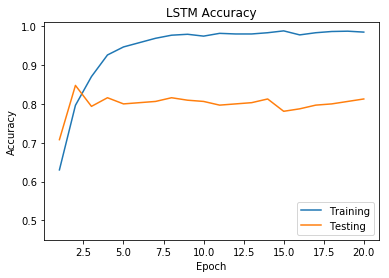

In [22]:
# Training Accuracy
x = np.arange(20)+1

plt.plot(x, model_hist_embedding.history['acc'])
plt.plot(x, model_hist_embedding.history['val_acc'])
plt.legend(['Training', 'Testing'], loc='lower right')
plt.ylabel("Accuracy")
axes = plt.gca()
axes.set_ylim([0.45,1.01])
plt.xlabel("Epoch")
plt.title("LSTM Accuracy")
plt.show()

In [23]:
#model_hist_embedding.model.save("../../wyns/data/climate_sentiment_m2.h5")